# H-Kr Scattering

In [2]:
import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import random
from random import randint
import scipy.constants as const
from scipy.signal import find_peaks


## Step 1: solving the Schrodinger equation

In [3]:

E = 1.5 #meV
epsilon = 5.99 # meV
sigma = 2. # Angstrom
rmax = 200 # Angstrom
h = 0.01 # spacing
N = rmax/h #number of points
r = np.arange(h/10, rmax, h)
l = 9


# - Masses:
#Kr mass = 83.798 u
#H mass = 1.008 u
# 1 u = 931.494 MeV
m_Kr= 83.798 #u
m_H = 1.008 #u
m = 931.494 * m_Kr * m_H /(m_Kr+ m_H) #MeV/c^2      reduced mass

# - Costants:
h_bar_Js = const.hbar #hbar in Js
h_bar = h_bar_Js / (1.6e-19) # hbar in eVs
c=const.c

# - Useful quantities:
a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
b = (4*epsilon * (sigma**12) /(25*a))**(0.1)

In [5]:
# Potential
def V(r,s):
    V = 4*epsilon * ((s/r)**12 - (s/r)**6) #meV
    return V


# Numerov
def Numerov(E,h,l,r,s):
    y = np.zeros(len(r))
    k = np.zeros(len(r))
    # Initialization of values
    
    for j in range(2, len(r)):
        k[j] = (1/a)*(E-V(r[j],s))-l*(l+1)/(r[j])**2
    
  
 
    for j in range(0, len(r)-1):
        
        if r[j]<=sigma/2:
            y[j]=np.exp(-(b/r[j])**5)
        else:
            y[j+1] = (-y[j-1]*(1+h**2/12*k[j-1])+2*y[j]*(1-(5*h**2)/12*k[j]))/((1+h**2/12*k[j+1]))

    return y


# Normalization
def normalize(psi,x):
  """ Normalization of the wavefunction calculing the integral of the wavefunction"""
  # Step 1: Compute the modulus squared of the wave function
  mod_squared_psi = np.abs(psi)**2

  # Step 2: Integrate the modulus squared over all space
  integral_value = simpson(mod_squared_psi, x)

  # Step 3: Calculate the normalization constant
  normalization_constant = 1 / np.sqrt(np.abs(integral_value))

  # Step 4: Apply the normalization constant
  normalized_psi = [y*normalization_constant for y in psi]
  return normalized_psi



verify that, for large r, the solutions are oscillatory with a phase depending on l

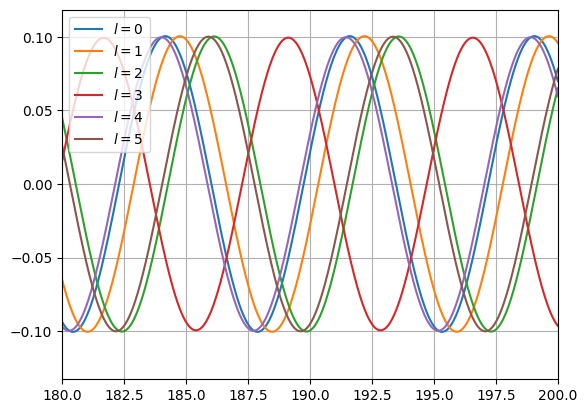

In [6]:
fig, ax = plt.subplots()
ax.set_xlim(180,200)
for j in range(6):
    psi = Numerov(E,h,j,r,sigma)
    PSI = normalize(psi,r)
    ax.plot(r, PSI, label=rf'$l={j}$')   
plt.legend(loc='best')
plt.grid()
plt.show()

## Step 2: phase shifts

define Bessel functions using the recursive method introduced in class

In [7]:
# Define Bessel functions

def j_1(r):
    return np.sin(r)/(r**2) - np.cos(r)/r
    
def n_1(r):
    return -np.cos(r)/(r**2) - np.sin(r)/r
    
    
def j_0(r):
    return np.sin(r)/r
    
def n_0(r):
    return -np.cos(r)/r
    
'''
 define the recursion relations
 input: l - order of bessel
        sl - l-th bessel evaluated at r
        sl1 - (l-1)-th bessel evaluated at r
        r - point to evaluate the bessel
 output: l+1 bessel, evaluated at r
'''
def recursive_bessel(l,sl,sl1,r):
    return ((2*l+1)/(r))*sl - sl1

'''   
 define a function to create a matrix of Bessel functions
 input: l - maximum order of bessel, 
        r - array of r values
 output: two matrices of Bessels (one of first kind, one of second kind) of order 0,...,l-1 evaluated on an array r
''' 
def Bessel_l(l,r):
    bess_matj = np.zeros((l,len(r)))
    bess_matn = np.zeros((l,len(r)))

    for j in range(len(r)):
        bess_matj[0][j] = j_0(r[j])
        bess_matn[0][j] = n_0(r[j])
        bess_matj[1][j] = j_1(r[j])
        bess_matn[1][j] = n_1(r[j])
        
    for w in range(2,l):
        for j in range(len(r)):
            bess_matj[w][j] = recursive_bessel(w-1,bess_matj[w-1][j], bess_matj[w-2][j],r[j])
            bess_matn[w][j] = recursive_bessel(w-1,bess_matn[w-1][j], bess_matn[w-2][j],r[j])
            
    return bess_matj, bess_matn
  

Compare the recursion-relation Bessels against Scipy

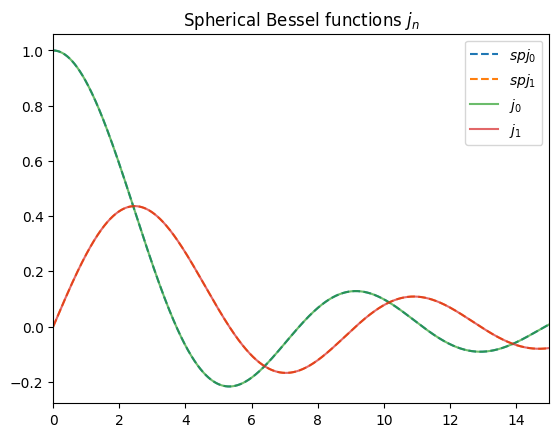

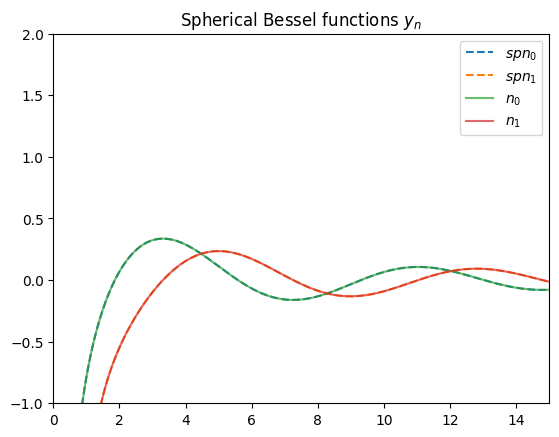

In [8]:
from scipy.special import spherical_jn
from scipy.special import spherical_yn

# bessels from recursion relations
jj, nn = Bessel_l(l,np.sqrt(1/a*E)*r) 


#first plot: spherical bessel functions of the first kind
fig, ax = plt.subplots()
ax.set_xlim(0, 15)
ax.set_title(r'Spherical Bessel functions $j_n$')
# scipy bessels are dashed
for n in np.arange(0, 2):
    ax.plot(r, spherical_jn(n, np.sqrt(1/a*E)*r), label=rf'$spj_{n}$', linestyle='dashed')   
# our bessels are solid
for n in np.arange(0, 2):
    ax.plot(r, jj[n][:], label=rf'$j_{n}$', alpha=0.7)
plt.legend(loc='best')
plt.show()

#second plot: spherical bessels of the second kind
fig, ax = plt.subplots()
ax.set_xlim(0, 15)
ax.set_ylim(-1,2)
ax.set_title(r'Spherical Bessel functions $y_n$')
# scipy bessels are dashed
for n in np.arange(0, 2):
    ax.plot(r, spherical_yn(n,np.sqrt(1/a*E)*r), label=rf'$spn_{n}$', linestyle='dashed')   
# our bessels are solid
for n in np.arange(0, 2):
    ax.plot(r, nn[n][:], label=rf'$n_{n}$', alpha=0.7)
plt.legend(loc='best')
plt.show()



Now onto computing the phase shifts.

First, define a phase-shift function

In [9]:
'''
define phase shift function
input: r1,r2 - two points to evaluate the phase shift
       r - array of r values for numerov
       l - angular momentum
       En - energy
       lmax - maximum order of bessel
       sigma - parameter of the potential
output: phase shift delta_l as defined in class
'''
def Phase_shift(r1,r2,r,l,En,lmax,sigma):
    jj, nn = Bessel_l(lmax,np.sqrt(1/a*En)*r)
    psi = Numerov(En,h,l,r,sigma)
    u = normalize(psi,r)
    kk=(u[r1]*r[r2])/(u[r2]*r[r1])
    tan_delta_l=(kk*jj[l][r2]-jj[l][r1])/(kk*nn[l][r2]-nn[l][r1])
    delta_l=np.arctan(tan_delta_l)
    return delta_l

# a simpler phase shift function if i only want tan delta l
def Phase_shift_tg(r1,r2,r,l,En,lmax,sigma):
    jj, nn = Bessel_l(lmax,np.sqrt(1/a*En)*r)
    psi = Numerov(En,h,l,r,sigma)
    u = normalize(psi,r)
    kk=(u[r1]*r[r2])/(u[r2]*r[r1])
    tan_delta_l=(kk*jj[l][r2]-jj[l][r1])/(kk*nn[l][r2]-nn[l][r1])
    return tan_delta_l




verify that the phase shift we find this way is independent of the choice of the two points r1,r2, for several energies and angular momenta

In [4]:
# (this cell takes forever to run)
#Define E and l vectors
energy_step = 0.03
Evec = [round(z,3) for z in np.arange(0.0,3.6,energy_step)]
Evec[0] = Evec[1]/10
lvec=[z for z in range(0,l,1)]
rep=10
lmax=l

SHIFTS = np.zeros((len(lvec),len(Evec),rep))

for i in range(len(lvec)):
    for j in range(len(Evec)):
        for k in range(rep):
            r1 =randint(6000,len(r)-1)
            rr=r[r1]*4/5-20*k*h
            r2 = round(rr/h)
            SHIFTS[i][j][k]=Phase_shift(r1,r2,r,lvec[i],Evec[j],lmax,sigma)

NameError: name 'Phase_shift' is not defined

plot the result from the previous cell

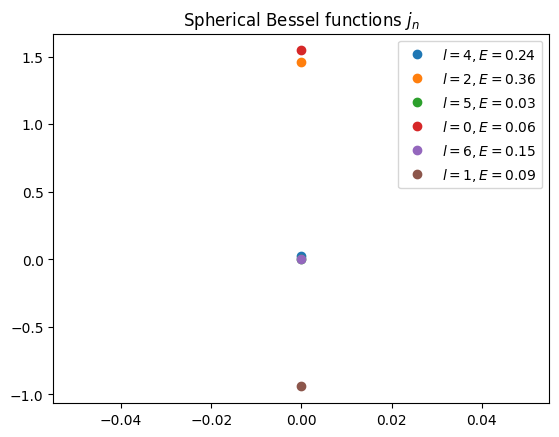

In [86]:
t = [z for z in range(0,rep,1)]

fig, ax = plt.subplots()
ax.set_title(r'Spherical Bessel functions $j_n$')
for j in range(6):
    aa = randint(0,len(Evec)-1)
    bb = randint(0,len(lvec)-1)
    ax.plot(t, SHIFTS[bb][aa][:], 'o',label=rf'$l={bb}, E={aa*energy_step}$')   

plt.legend(loc='best')
plt.show()

Mean and variance of phase shifts

IndexError: index 40 is out of bounds for axis 0 with size 17

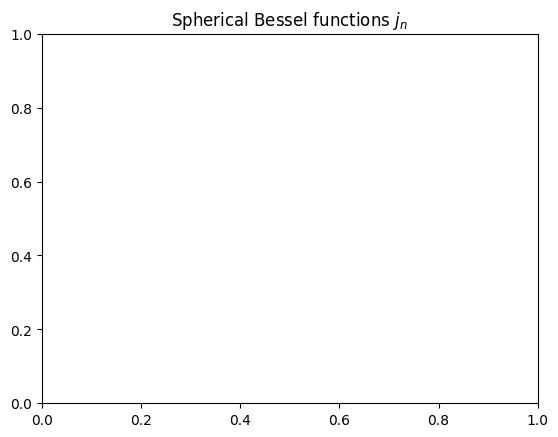

In [87]:
mean_shift=np.zeros((len(lvec),len(Evec)))
var_shift=np.zeros((len(lvec),len(Evec)))

for i in range(len(lvec)):
    for j in range(len(Evec)):
        sum=0
        sumq=0
        for k in range(rep):
            sum+=SHIFTS[i][j][k]
            sumq+=SHIFTS[i][j][k]**2        
        mean_shift[i][j]=sum/rep
        var_shift[i][j]=sumq/rep  - (sum/rep)**2
        

        
fig, ax = plt.subplots()
ax.set_title(r'Spherical Bessel functions $j_n$')
for j in range(5):
    aa = [round(1.2/energy_step),round(2.6/energy_step),round(0.005/energy_step),round(0.4/energy_step),round(2.7/energy_step)]#randint(0,len(Evec)-1)
    bb = [3,0,3,0,3]#randint(0,len(lvec)-1)
    ax.plot(t, SHIFTS[bb[j]][aa[j]][:], 'o',label=rf'$l={bb[j]}, E={aa[j]*energy_step}$')   
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]], label=rf'$mean l={bb[j]}')
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]]+var_shift[bb[j]][aa[j]], linestyle='dashed')
    ax.plot(t, np.ones(len(t))*mean_shift[bb[j]][aa[j]]-var_shift[bb[j]][aa[j]],  linestyle='dashed')

plt.legend(loc='best')
plt.show()



In [60]:
#alternative approach: just take 1 phase shift for each (E,l), equidistant in log space
l = 9
#Define E and l vectors
#energy_step = 0.03
#Evec = [round(z,3) for z in np.arange(0.0,3.6,energy_step)]
#Evec[0] = Evec[1]/10
#lvec=[z for z in range(0,l,1)]
Evec = np.logspace(-1,2, num=50)
lvec=[z for z in range(0,l,1)]

rep=1
lmax=l

mean_shift_tg = np.zeros((len(lvec),len(Evec)))

for i in range(len(lvec)):
    for j in range(len(Evec)):
            r1 =randint(6000,len(r)-1)
            rr=r[r1]*4/5-20*k*h
            r2= round(rr/h)
            mean_shift_tg[i][j]=Phase_shift_tg(r1,r2,r,lvec[i],Evec[j],lmax,sigma)

## Part 3: Cross section

\begin{equation}
\sigma_{\text{tot}}= \frac{4\pi a}{E} \sum_l (2l+1) \sin^2 \delta_l
\end{equation}
for $a=\hbar^2/2m$

compare what happens when using 6,7,8 as maximum angular momentum quantum number

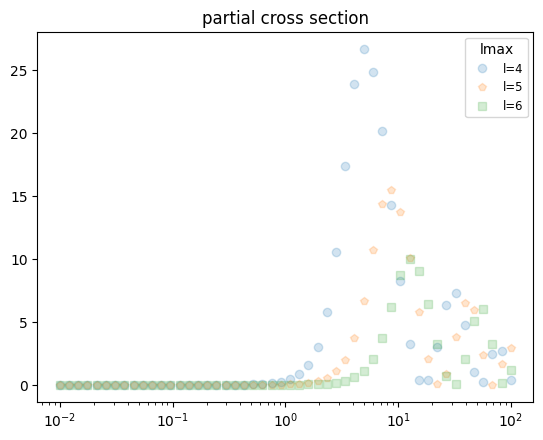

In [61]:
############## compute only partial cross sections
def partialcross(l,shifts):
    cross = np.zeros(len(Evec))
    for i in range(len(Evec)):
        a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
        factor= 4 * a * np.pi/Evec[i]
        sum = 0
        tan_l = shifts[l][i]
        sin_squared = tan_l**2/(1+tan_l**2)
        sum+=(2*l+1)*sin_squared
        
        cross[i]=(factor*sum)
    return cross

pcross4 = partialcross(4,mean_shift_tg)
pcross5 = partialcross(5,mean_shift_tg)
pcross6 = partialcross(6,mean_shift_tg)


fig, ax = plt.subplots()
ax.set_title(r'partial cross section')
ax.set_xscale('log')
#ax.set_ylim(0.9e2, 500)
#ax.set_xlim(0.1, 5)
ax.plot(Evec, pcross4, 'o', alpha=.2)  
ax.plot(Evec, pcross5, 'p', alpha=.2)  
ax.plot(Evec, pcross6, 's', alpha=.2)  
#ax.set_ylim(10,500)
plt.legend(['l=4', 'l=5', 'l=6'], loc='best', title='lmax', fontsize='small')
plt.show()

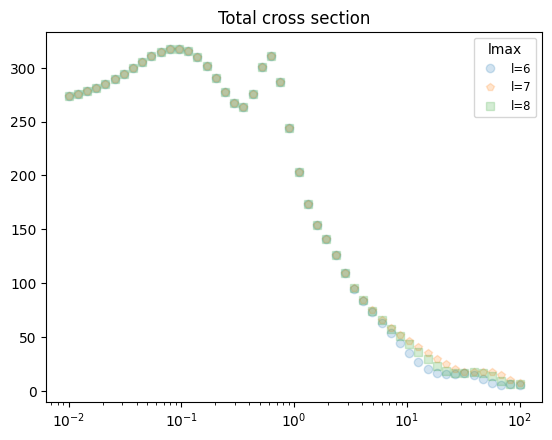

In [62]:
def totalcross(l,shifts):
    cross = np.zeros(len(Evec))
    for i in range(len(Evec)):
        a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m) #1e-3 for conversion meV, eV -> meV - 1e-10 for conversion m -> Å
        factor= 4 * a * np.pi/Evec[i]
        sum = 0
        for k in range(l):
            tan_l = shifts[k][i]
            sin_squared = tan_l**2/(1+tan_l**2)
            sum+=(2*k+1)*sin_squared
        
        cross[i]=(factor*sum)
   
    return cross

cross6 = totalcross(6,mean_shift_tg)
cross7 = totalcross(7,mean_shift_tg)
cross8 = totalcross(8,mean_shift_tg)

fig, ax = plt.subplots()
ax.set_title(r'Total cross section')
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim(0.9e2, 500)
#ax.set_xlim(0.1, 5)
ax.plot(Evec, cross6, 'o', alpha=.2)  
ax.plot(Evec, cross8, 'p', alpha=.2)  
ax.plot(Evec, cross7, 's', alpha=.2)  
#ax.set_ylim(10,500)
plt.legend(['l=6', 'l=7', 'l=8'], loc='best', title='lmax', fontsize='small')
plt.show()


since there's no visible difference, we stick to l=6 for computational ease.

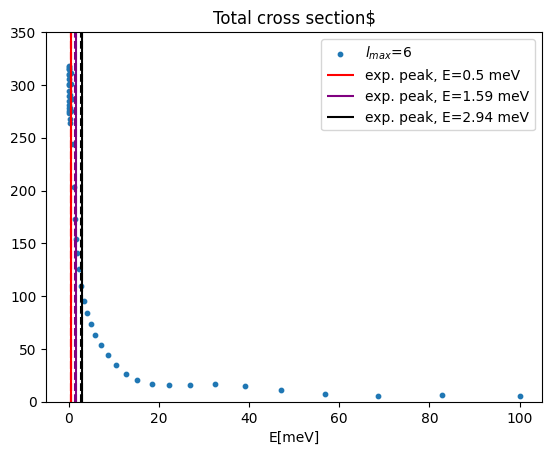

In [63]:
E_exp = [0.50,1.59,2.94] #meV
E_exp_err = [0.02,0.06,0.1] #meV

fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
ax.set_ylim(0,350)
plt.scatter(Evec,cross6,label='$l_{max}$='f'{6}',s=10)
plt.xlabel('E[meV]')


plt.vlines(E_exp[0],0,500, color='red', label=f'exp. peak, E={E_exp[0]} meV')
plt.vlines(E_exp[0]+E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[0]-E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[1],0,500, color='purple', label=f'exp. peak, E={E_exp[1]} meV')
plt.vlines(E_exp[1]+E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[1]-E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[2],0,500, color='black', label=f'exp. peak, E={E_exp[2]} meV')
plt.vlines(E_exp[2]+E_exp_err[2],0,500, color='black',linestyle='--')
plt.vlines(E_exp[2]-E_exp_err[2],0,500, color='black',linestyle='--')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


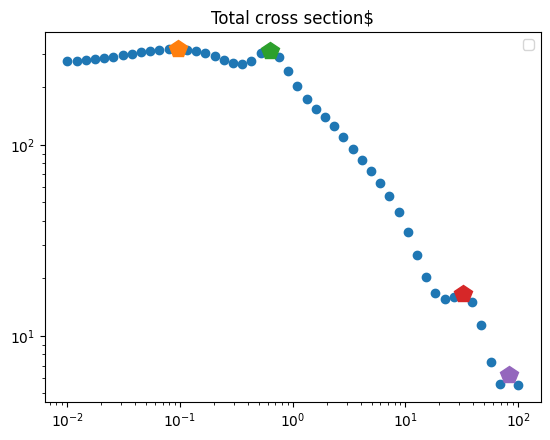

In [65]:
peaks_position6=[]
peak6, peak_position6 = find_peaks(cross6)
peaks_position6.append(list(peak6))

fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(Evec,cross6,'o')
for i in range(len(peak6)):
    ax.plot(Evec[peak6[i]], cross6[peak6[i]], 'p', markersize=13)
plt.legend(loc='best')
plt.show()

In [66]:

E_comp6=[]
for i in range(len(peaks_position6)):
  for j in peaks_position6[i]:
    E_comp6.append(Evec[j])

  
print(E_comp6)
  
E_comp7=[]
for i in range(len(peaks_position7)):
  for j in peaks_position7[i]:
    E_comp7.append(Evec[j])


print(E_comp7)

E_comp8=[]
for i in range(len(peaks_position8)):
  for j in peaks_position8[i]:
    E_comp8.append(Evec[j])

  
  
  
print(E_comp8)


[0.09540954763499938, 0.6250551925273969, 32.374575428176435, 82.86427728546842]


NameError: name 'peaks_position7' is not defined

In [67]:
# Calculation of the parameter Delta

E_comp6=np.array(E_comp6, dtype='float32')
E_comp7=np.array(E_comp7, dtype='float32')
E_comp8=np.array(E_comp8, dtype='float32')


for i in range(len(E_comp6)):
  delta6=0
  delta6+=(E_exp[i]-E_comp6[i])**2
  
for i in range(len(E_comp7)):
  delta7=0
  delta7+=(E_exp[i]-E_comp7[i])**2

for i in range(len(E_comp8)):
  delta8=0
  delta8+=(E_exp[i]-E_comp8[i])**2  

  
print(delta6,delta7,delta8)
  


NameError: name 'E_comp8' is not defined

In [68]:
sigma_step = 0.05 #Å
sigmavec = np.arange(2.9,3.5,sigma_step) #Å


deltasigma = np.zeros(len(sigmavec))


for i in range(len(sigmavec)):
    a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m)
    b = (4*epsilon * (sigmavec[i]**12) /(25*a))**(0.1)
    SHIFTS = np.zeros((len(lvec),len(Evec)))
    for k in range(len(lvec)):
        for j in range(len(Evec)):
            r1 =randint(6000,len(r)-1)
            rr=r[r1]*4/5-20*k*h
            r2 = round(rr/h)
            SHIFTS[k][j]=Phase_shift(r1,r2,r,lvec[k],Evec[j],lmax,sigmavec[i])
    
    crossect = totalcross(6,SHIFTS)
    peak, peak_position = find_peaks(crossect)
    E_comp=[]
    for i in range(len(peak_position)):
        for j in peak_position[i]:
            E_comp.append(Evec[j])
    
    E_comp=np.array(E_comp, dtype='float32')
    delta=0
    for i in range(len(E_comp)):
        delta+=(E_exp[i]-E_comp[i])**2
    
    deltasigma[i]=delta
    

min_delta=min(deltasigma)
index = 0
for j in range(len(deltasigma)):
    deltasigma[j]==min_delta
    index = j

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [41]:
a = 1e-3 * h_bar**2 *(c*1e10)**2/(2*m)
b = (4*epsilon * (min_delta**12) /(25*a))**(0.1)
SHIFTS = np.zeros((len(lvec),len(Evec)))
for k in range(len(lvec)):
    for j in range(len(Evec)):
        r1 =randint(6000,len(r)-1)
        rr=r[r1]*4/5-20*k*h
        r2 = round(rr/h)
        SHIFTS[k][j]=Phase_shift(r1,r2,r,lvec[k],Evec[j],lmax,sigmavec[index])
    
crossect = totalcross(6,SHIFTS)
peak, peak_position = find_peaks(crossect)
E_comp=[]
for i in range(len(peak_position)):
    for j in peak_position[i]:
        E_comp.append(Evec[j])
    
E_comp=np.array(E_comp, dtype='float32')
for i in range(len(E_comp)):
    delta=0
    delta+=(E_exp[i]-E_comp[i])**2
    

NameError: name 'min_delta' is not defined

In [40]:

print(peak,delta)


fig, ax = plt.subplots()
ax.set_title(r'Total cross section$')
ax.set_ylim(0,500)
plt.scatter(Evec,crossect,label='$l_{max}$='f'{6}',s=10)
plt.xlabel('E[meV]')


plt.vlines(E_exp[0],0,500, color='red', label=f'exp. peak, E={E_exp[0]} meV')
plt.vlines(E_exp[0]+E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[0]-E_exp_err[0],0,500, color='red',linestyle='--')
plt.vlines(E_exp[1],0,500, color='purple', label=f'exp. peak, E={E_exp[1]} meV')
plt.vlines(E_exp[1]+E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[1]-E_exp_err[1],0,500, color='purple',linestyle='--')
plt.vlines(E_exp[2],0,500, color='black', label=f'exp. peak, E={E_exp[2]} meV')
plt.vlines(E_exp[2]+E_exp_err[2],0,500, color='black',linestyle='--')
plt.vlines(E_exp[2]-E_exp_err[2],0,500, color='black',linestyle='--')
plt.legend()
plt.show()

NameError: name 'peak' is not defined